## 학습된 영어 알파벳 생성 모델로 이름 생성하기
- 생성 모델은 알파벳 별로 GAN-model/[alphabet]-generator 형식으로 저장되어 있음
- 세번째 셀에 이름을 입력하면 모델의 이미지 생성 -> 이미지 처리 과정을 거쳐 handwriting_name.jpg로 저장됨

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [ ]:
# 이름 입력 받기

name = input()
name = name.replace(" ", "").lower()

Yula


In [ ]:
# 모델로 각 알파벳 생성

def generate(num):
  model_name = '/content/gdrive/My Drive/GAN-model/'+ name[num] + '-generator'
  model = tf.keras.models.load_model(model_name, compile=False)
  new_generated_image = model(tf.random.normal([16, 100]), training=False)
  plt.imshow(new_generated_image[1, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.savefig('original'+str(num)+'.jpg')

In [ ]:
# 알파벳 이미지 공백 없게 자르기

def crop_image(num):
  image = cv2.imread('original'+str(num)+'.jpg', 0)
  blur = cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0)
  ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
  edged = cv2.Canny(blur, 10, 250)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
  contours, _ = cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  total = 0
  contours_xy = np.array(contours)
  x_min, x_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][0])
      x_min = min(value)
      x_max = max(value)
 
  y_min, y_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][1])
      y_min = min(value)
      y_max = max(value)

  x = x_min
  y = y_min
  w = x_max-x_min
  h = y_max-y_min

  img_trim = image[y:y+h, x:x+w]

  return img_trim

In [ ]:
# 알파벳 이미지들 하나로 합쳐서 저장

merged_image = np.zeros((2, 2))

def merge_image(single_image):
  global merged_image

  if len(merged_image) < len(single_image):
    width = len(merged_image[0])
    height = len(single_image)
    new_merged_image = np.full((height, width), 255)
    new_merged_image[height-len(merged_image):,:] = merged_image
    merged_image = np.concatenate((new_merged_image, single_image), axis=1)

  else:
    width = len(single_image[0])
    height = len(merged_image)
    new_single_image = np.full((height, width), 255)
    new_single_image[height-len(single_image):,:] = single_image
    merged_image = np.concatenate((merged_image, new_single_image), axis=1)

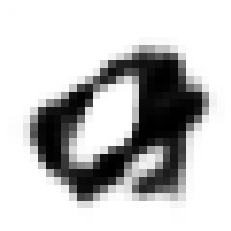

In [ ]:
for num in range(len(name)):
  generate(num)
  single_image = crop_image(num)
  merge_image(single_image)

image = Image.fromarray(merged_image.astype('uint8'), 'L')
image.save('handwriting_name.jpg')